In [11]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For building and training a neural network
import torch
import torch.nn as nn
import torch.optim as optim


In [12]:
import json
import numpy as np
import os

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # Assuming 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            # Extract x, y coordinates only
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints, 
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)


# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)


In [13]:
def normalize_keypoints(X):
    for i, keypoints in enumerate(X):
        # Reshape into pairs of (x, y)
        keypoints = keypoints.reshape(-1, 2)
        # Normalize by the range of keypoints
        x_min, y_min = keypoints.min(axis=0)
        x_max, y_max = keypoints.max(axis=0)
        X[i] = ((keypoints - [x_min, y_min]) / (x_max - x_min)).flatten()
    return X

X = normalize_keypoints(X)


/var/folders/yh/61qhjdf50_74bpxh_zh688bm0000gn/T/ipykernel_3063/852071376.py:8: RuntimeWarning: invalid value encountered in divide
  X[i] = ((keypoints - [x_min, y_min]) / (x_max - x_min)).flatten()


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       458
           1       0.81      0.83      0.82       396
           2       0.85      0.90      0.87       345
           3       0.85      0.81      0.83       424
           4       0.94      0.94      0.94       406
           5       0.89      0.90      0.89       445
           6       0.92      0.93      0.93       504
           7       0.87      0.72      0.78       259
           8       0.87      0.87      0.87       296

    accuracy                           0.88      3533
   macro avg       0.87      0.87      0.87      3533
weighted avg       0.88      0.88      0.87      3533



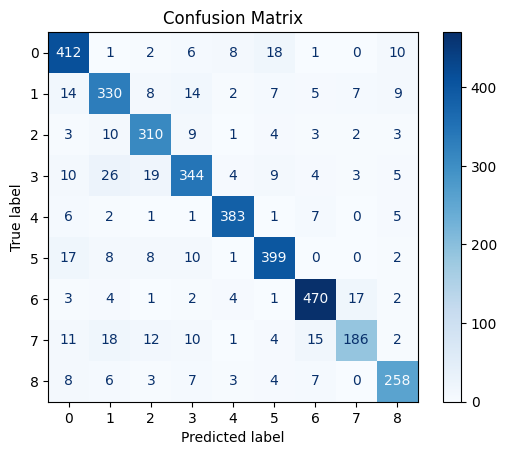

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       458
           1       0.82      0.83      0.82       396
           2       0.84      0.89      0.87       345
           3       0.86      0.82      0.84       424
           4       0.95      0.94      0.94       406
           5       0.88      0.90      0.89       445
           6       0.91      0.94      0.93       504
           7       0.87      0.72      0.79       259
           8       0.86      0.86      0.86       296

    accuracy                           0.87      3533
   macro avg       0.87      0.87      0.87      3533
weighted avg       0.87      0.87      0.87      3533



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class PoseClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PoseClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# Model setup
input_size = X_train.shape[1]
num_classes = len(set(y))
model = PoseClassifier(input_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")


Epoch 1/50, Loss: nan, Val Loss: nan
Epoch 2/50, Loss: nan, Val Loss: nan
Epoch 3/50, Loss: nan, Val Loss: nan
Epoch 4/50, Loss: nan, Val Loss: nan
Epoch 5/50, Loss: nan, Val Loss: nan
Epoch 6/50, Loss: nan, Val Loss: nan
Epoch 7/50, Loss: nan, Val Loss: nan
Epoch 8/50, Loss: nan, Val Loss: nan
Epoch 9/50, Loss: nan, Val Loss: nan
Epoch 10/50, Loss: nan, Val Loss: nan
Epoch 11/50, Loss: nan, Val Loss: nan
Epoch 12/50, Loss: nan, Val Loss: nan
Epoch 13/50, Loss: nan, Val Loss: nan
Epoch 14/50, Loss: nan, Val Loss: nan
Epoch 15/50, Loss: nan, Val Loss: nan
Epoch 16/50, Loss: nan, Val Loss: nan
Epoch 17/50, Loss: nan, Val Loss: nan
Epoch 18/50, Loss: nan, Val Loss: nan
Epoch 19/50, Loss: nan, Val Loss: nan
Epoch 20/50, Loss: nan, Val Loss: nan
Epoch 21/50, Loss: nan, Val Loss: nan
Epoch 22/50, Loss: nan, Val Loss: nan
Epoch 23/50, Loss: nan, Val Loss: nan
Epoch 24/50, Loss: nan, Val Loss: nan
Epoch 25/50, Loss: nan, Val Loss: nan
Epoch 26/50, Loss: nan, Val Loss: nan
Epoch 27/50, Loss: na

In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(len(exercise_labels), activation='softmax')  # Output layer
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.1297 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.1359 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.1420 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.1372 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.1340 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.1322 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.1371 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.1375 - loss: nan - val_accuracy: 0.1296 - val_loss: nan
Epoch 9/

In [20]:
# Evaluate model
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

111/111 - 0s - 434us/step - accuracy: 0.1296 - loss: nan
Validation Loss: nan
Validation Accuracy: 0.12963487207889557
